# Understanding how changes in player behavior drive changes in rating over time

N.B. requires an implementation of the Elo algorithm which can be installed with the line below.

In [ ]:
!pip install elo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

df = pd.read_csv('chess_games.csv', sep='\t')
df.head(3)

,timestamp,outcome,moves_count,white_username,white_rating,black_username,black_rating,time_class,service,eco_name,...,black_blunders_per_middlegame,black_blunders_per_endgame,black_endgame_winrate,black_endgame_winrate_with_equal,black_endgame_winrate_with_advantage,black_endgame_winrate_with_disadvantage,black_long_thinking_outcome_score,black_time_advantage_score,black_significant_time_advantage_winrate,black_significant_time_disadvantage_winrate
0,1630368486,0,64,ieshuaganocry,1901,jdlax36,1869,blitz,SERVICE_LICHESS,Queen's Pawn Game: Mason Attack,...,0.1000,0.0833,1.0000,None,1.0000,None,0.6000,0.4228,None,1
1,1630524120,1,20,endriu777,1870,ieshuaganocry,1895,blitz,SERVICE_LICHESS,"King's Gambit Accepted, King's Knight Gambit",...,0.0833,None,None,None,None,None,None,0.0000,None,None
2,1630522980,0,40,hooligandi,1808,ieshuaganocry,1901,blitz,SERVICE_LICHESS,Four Knights Game: Scotch Variation Accepted,...,0.1500,0.0000,1.0000,None,1.0000,None,0.6667,0.0130,None,1


In [2]:
# Quick fixes: None to NaN and convert to numeric datatype
df.replace("None", np.nan, inplace=True)
df[df.columns[12:]] = df[df.columns[12:]].astype('float')

All matches are played by Moscow-based expert player Anton Gora aka [ieshuaganocry](https://lichess.org/@/ieshuaganocry). I am going to answer questions about Anton's play rather than player trends in general. The first step is to reorganize the data to focus on Anton. I will then compute the change in his rating after each match. I will not assume his new rating is the next rating in case some games are missing from the dataset, or the rating host has some kind of rating decay mechanism in place (I am not sure Lichess does this but it is a practice I have seen before). This also allows us to use the last data point, for whatever that is worth.

In [5]:
from elo import rate_1vs1

PLAYER = 'ieshuaganocry'


def get_white_elo_change(row):
    if row['outcome'] == 1:
        return rate_1vs1(row['white_rating'], row['black_rating'])[0] - row['white_rating']
    elif row['outcome'] == 0:
        return rate_1vs1(row['black_rating'], row['white_rating'])[1] - row['white_rating']
    else:
        return rate_1vs1(row['white_rating'], row['black_rating'], drawn=True)[0] - row['white_rating']
    

def invert_outcome(x):
    if x == 1:
        return 0
    elif x == 0:
        return 1
    else:
        return x
    

def rename_col(col):
    if col.startswith('white'):
        return "player" + col[5:]
    elif col.startswith('black'):
        return "opponent" + col[5:]
    else:
        return col


white_cols = df.columns[df.columns.str.startswith('white')].tolist()
black_cols = df.columns[df.columns.str.startswith('black')].tolist()

# Make Anton the white player, flip white and black stats around if needed
player_black = df.black_username == PLAYER
white_df = df[~player_black]
white_df['player_white'] = 1
white_df['elo_change'] = white_df.apply(get_white_elo_change, axis=1)

black_df = df[player_black]
black_df['player_white'] = 0
black_df[white_cols], black_df[black_cols] = black_df[black_cols], black_df[white_cols]
black_df['outcome'] = black_df['outcome'].apply(invert_outcome)
black_df['elo_change'] = black_df.apply(get_white_elo_change, axis=1)

new_df = pd.concat([white_df, black_df])
new_cols = list(map(rename_col, new_df.columns.values))
new_df.columns = new_cols

new_df[['player_white', 'player_username', 'player_rating', 'opponent_rating', 'outcome', 'elo_change']].head()

,player_white,player_username,player_rating,opponent_rating,outcome,elo_change
0,1,ieshuaganocry,1901,1869,0,-5.459219
3,1,ieshuaganocry,1901,1808,1,3.692697
5,1,ieshuaganocry,1901,1808,1,3.692697
7,1,ieshuaganocry,1901,1904,1,5.043172
11,1,ieshuaganocry,1884,1964,0,-3.868632


Let's look at how Anton has been doing over time. It appears that a separate rating is tracked for each game type.

time_class
blitz      AxesSubplot(0.125,0.125;0.775x0.755)
bullet     AxesSubplot(0.125,0.125;0.775x0.755)
classic    AxesSubplot(0.125,0.125;0.775x0.755)
rapid      AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

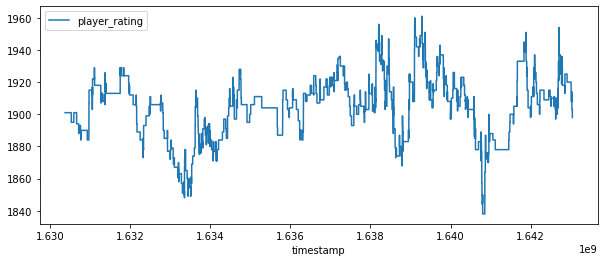

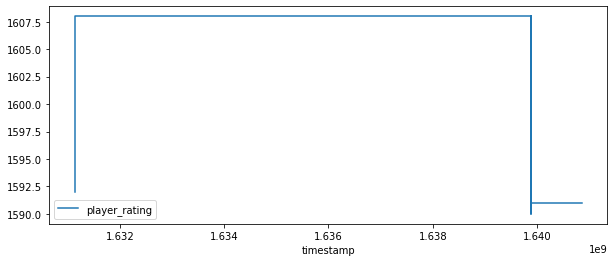

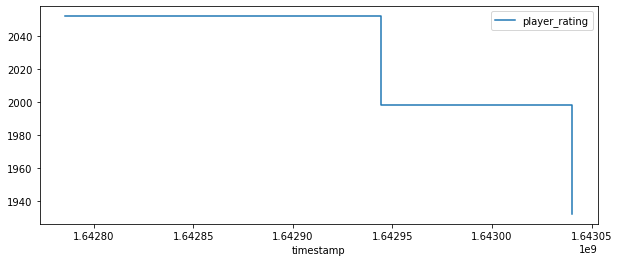

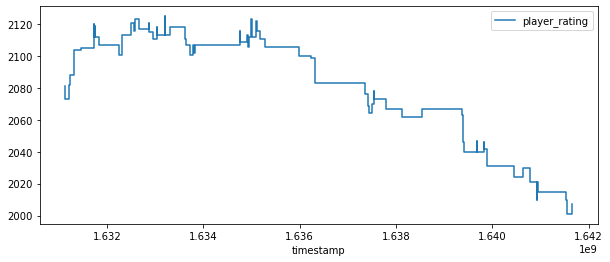

In [6]:
new_df.sort_values('timestamp').groupby('time_class').plot(x='timestamp', y='player_rating', figsize=(10, 4), drawstyle="steps-post")


Anton mostly plays blitz over this interval and has been getting steadily worse at rapid chess.

## Discretization of Elo change

I will simplify the data by binning Elo changes into "gaining", "losing", and "maintaining". I need to pick a threshold indicating that the elo change was large enough to classify as gaining or losing as opposed to maintaining. I can do this such that the three outcome classes are balanced, which may be useful later.

In [7]:
threshold = np.percentile(new_df['elo_change'].apply(abs), 100/3)
print(f"Elo must change by more than {threshold:0.1f} after a match to consider it to be losing/gaining")

Elo must change by more than 4.4 after a match to consider it to be losing/gaining


Text(0, 0.5, 'Count')

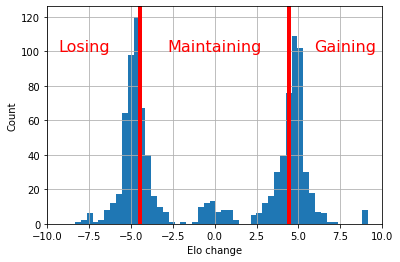

In [9]:
new_df['elo_change'].hist(bins=50)
plt.axvline(-threshold, c='r', lw=4)
plt.axvline(threshold, c='r', lw=4)
plt.text(-1.75 * threshold, 100, "Losing", horizontalalignment='center', c='r', fontsize=16)
plt.text(0, 100, "Maintaining", horizontalalignment='center', c='r', fontsize=16)
plt.text(1.75 * threshold, 100, "Gaining", horizontalalignment='center', c='r', fontsize=16)
plt.xlim([-10, 10])
plt.xlabel("Elo change")
plt.ylabel("Count")

In [10]:
def classify_elo_change(elo):
    if elo > threshold: return 1
    elif elo < -threshold: return -1
    else: return 0

new_df['elo_status'] = new_df['elo_change'].apply(classify_elo_change)

Confirm the classes are roughly balanced

In [11]:
new_df['elo_status'].value_counts()

-1    342
 0    337
 1    321
Name: elo_status, dtype: int64

## Errors at different phases of the game

I notice there are a set of related features that look at the frequencies of different severities of errors at different phases of the game. I want to see how these values change for Anton when he is gaining/losing Elo relative to maintaining.

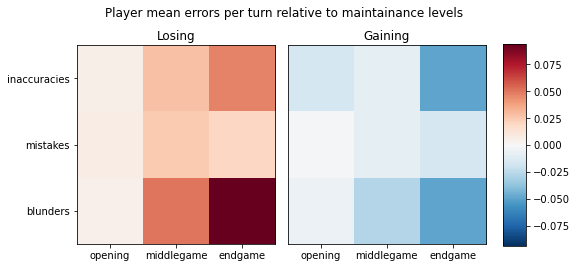

In [16]:
severities = ['inaccuracies', 'mistakes', 'blunders']
phases = ['opening', 'middlegame', 'endgame']

def arrange_errors(df, who='player'):
    out = np.empty((3, 3), dtype='float')
    for row, severity in enumerate(severities):
        for col, phase in enumerate(phases):
            col_name = [f'{who}_{severity}_per_{phase}']
            out[row, col] = df[col_name]
    return out


def error_grid(df, who='player'):
    means = df.groupby('elo_status').mean()
    gaining_diff = arrange_errors(means.loc[1] - means.loc[0], who)
    losing_diff = arrange_errors(means.loc[-1] - means.loc[0], who)

    rng = np.maximum(abs(gaining_diff).max(), abs(losing_diff).max())

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    ticks = [0, 1, 2]
    
    axs[0].imshow(losing_diff, vmin=-rng, vmax=rng, cmap='RdBu_r')
    axs[0].set_xticks(ticks, phases)
    axs[0].set_yticks(ticks, severities)
    axs[0].set_title("Losing")

    m = axs[1].imshow(gaining_diff, vmin=-rng, vmax=rng, cmap='RdBu_r')
    axs[1].set_xticks(ticks, phases)
    axs[1].set_yticks([], [])
    axs[1].set_title("Gaining")

    plt.tight_layout()

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    plt.colorbar(m, cax=cbar_ax)

    plt.suptitle(f"{who.capitalize()} mean errors per turn relative to maintainance levels")
    

error_grid(new_df, 'player')

We see that late game blunders are a common way for Anton to lose rating, whereas having fewer late game inaccuracies and blunders leads to rating gain. Opening errors of all types appear to be weak determinants of Elo change. This indicates that **Anton's late game performance correlates with changes in his rating**.

This raises the question: what if symmetric changes in opponent performance are driving Anton's performance, rather than his own ability to avoid errors. We will challenge the notion that Anton's play is the main determinant of his rating.

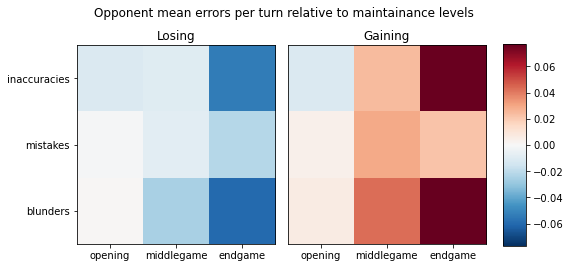

In [333]:
error_grid(new_df, 'opponent')

Anton's opponents tend to make mistakes and blunders in the midgame in games where Anton's rating improves. This might indicate that Anton is especially good at capitalizing on opponent mistakes in the midgame even if his own midgame error rate is high. Surprisingly, Anton tends to gain rating when opponents have strong openings. This might indicate that Anton thrives on countering strong opening sequences.

## Numeric feature overview

Next I want to see how every numeric feature changes depending on the rating change outcome.

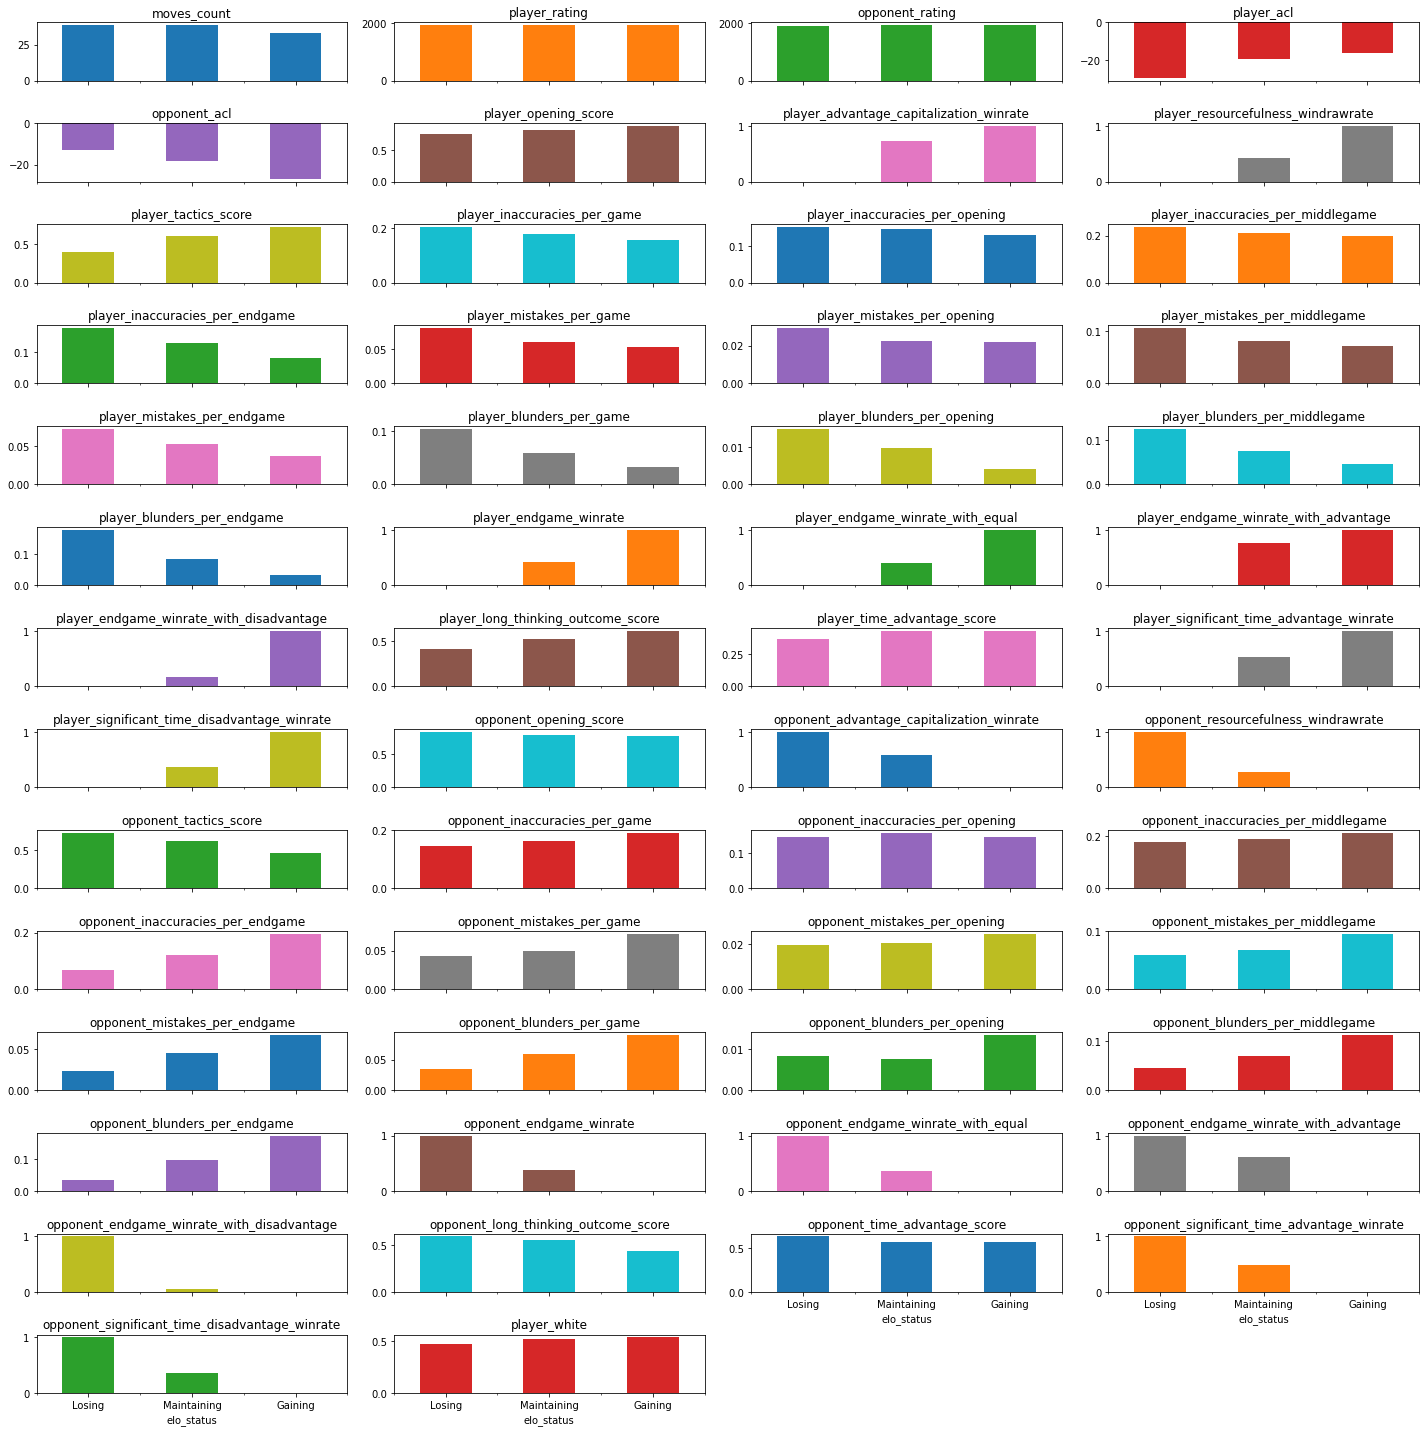

In [334]:
numeric_df = new_df.drop(columns=['timestamp', 'outcome', 'player_username', 'opponent_username', 'elo_change', 'time_class', 'service', 'eco_name', 'eco_code', 'eco_category'])
axs = numeric_df.groupby('elo_status').mean().plot(kind='bar', subplots=True, sharex=True, figsize=(20, 20), layout=(14, 4), legend=False, rot=0)
for ax in axs[-1, :]:
    ax.set_xticks([0, 1, 2], ["Losing", "Maintaining", "Gaining"])
plt.tight_layout()


### Global game features

- Anton **prefers shorter games**, which augments our observation that his late game performance is less consistent and tends to determine the outcome of the match.
- Anton seems to win about half the time regardless of piece color.

### Player features

- Unsurprisingly better tactics result in an increase in rating.
- Anton is able to convert advantages into wins, but he gains the most rating by recovering from a bad position.

### Categorical features: ECO name and category

Let's look at what opening strategies Anton tends to play when he is gaining, losing, or maintaining his rating. In this case, whether he is white or black determines his role in the strategy.

In [12]:
def top_value_count(x, n=4):
    return x.value_counts().head(n)

new_df.groupby(['elo_status', 'player_white'])['eco_name'].apply(top_value_count)

elo_status  player_white                                                   
-1          0             Russian Game: Urusov Gambit                          12
                          Russian Game: Nimzowitsch Attack                     11
                          Petrov's Defense                                      8
                          Queen's Pawn Game: Mason Attack                       8
            1             Queen's Pawn Game: Mason Attack                       6
                          French Defense: Advance Variation, Paulsen Attack     6
                          Sicilian Defense                                      6
                          French Defense: Normal Variation                      5
 0          0             Russian Game: Urusov Gambit                           9
                          Russian Game: Nimzowitsch Attack                      8
                          Petrov's Defense                                      7
                      

In [13]:
new_df.groupby(['elo_status', 'player_white'])['eco_category'].apply(top_value_count)

elo_status  player_white                         
-1          0             Russian Game               48
                          Queen's Pawn Game          21
                          Queen's Gambit Declined    20
                          Four Knights Game          16
            1             Sicilian Defense           33
                          French Defense             19
                          Queen's Pawn Game          15
                          Scotch Game                12
 0          0             Russian Game               38
                          Queen's Gambit Declined    21
                          Four Knights Game          16
                          Queen's Pawn Game          14
            1             Sicilian Defense           42
                          Queen's Pawn Game          22
                          French Defense             15
                          Scotch Game                14
 1          0             Russian Game               4

Surprisingly, Anton's opening strategies do not appear to be a strong determinant of his rating outcome.

## Modeling

So far we have looked at the relationship between individual features and outcomes, which does not allow for a causal interpretation because it ignores correlations in the features. I will use linear regression and ANOVA to account for these correlations. To deal with missing values I will train 3 separate models for short, medium, and long games. Instead of building a model to classify the match as being a rating loss, gain, or maintenance, I will use set up a regression to predict the continous-values rating change from the features.

Note that we can compare some coefficient magnitudes directly without scaling here because of consistent semantic meaning. Coefficents of features in units of "occurances per turn" can be taken directly as the relative contribution of the given occurance to the resulting rating change.

In [14]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def build_columns(phases):
    columns = []
    for who in ['player', 'opponent']:
        for severity in severities:
            for phase in phases:
                columns.append(f"{who}_{severity}_per_{phase}")
    return columns

formula_base = "elo_change ~ moves_count + player_white + player_tactics_score + opponent_tactics_score + player_opening_score + opponent_opening_score + "

In [17]:
model_short = ols(formula_base + " + ".join(build_columns(['opening'])), missing='drop', data=new_df).fit()
model_short.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             elo_change   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 10 Feb 2023   Prob (F-statistic):          5.64e-173
Time:                        18:00:02   Log-Likelihood:                -2541.0
No. Observations:                1000   AIC:                             5108.
Df Residuals:                     987   BIC:                             5172.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.0281      0.711     -0.040      0.968      -1.424       1.368
moves_count                          -0.0181      0.006     -3.234      0.001      -0.029      -0.007
player_white                          0.0472      0.198      0.238      0.812      -0.342       0.436
player_tactics_score                 10.1548      0.434     23.418      0.000       9.304      11.006
opponent_tactics_score               -9.2649      0.419    -22.131      0.000     -10.086      -8.443
player_opening_score                  0.1158      0.349      0.331      0.740      -0.570       0.801
opponent_opening_score                0.2888      0.331      0.872      0.383      -0.361       0.939
player_inaccuracies_per_opening       0.5828      0.868      0.671      0.502      -1.121       2.287
player_mistakes_per_opening           4.9043      2.206      2.223      0.026       0.576       9.233
player_blunders_per_opening           1.5492      3.369      0.460      0.646      -5.061       8.160
opponent_inaccuracies_per_opening    -0.4026      0.843     -0.478      0.633      -2.057       1.252
opponent_mistakes_per_opening        -2.8250      2.244     -1.259      0.208      -7.228       1.578
opponent_blunders_per_opening        -3.9278      3.013     -1.304      0.193      -9.841       1.985
==============================================================================
Omnibus:                       14.913   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.159
Skew:                           0.184   Prob(JB):                     6.91e-05
Kurtosis:                       3.569   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The most significant factors are the tactics scores. Anton benefits from shorter matches, which we've suspected, and can now quantify to say that **every turn of the game costs Anton 1/50th of a rating point!**

In [18]:
model_mid = ols(formula_base + " + ".join(build_columns(['opening', 'middlegame'])), missing='drop', data=new_df).fit()
model_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             elo_change   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     73.48
Date:                Fri, 10 Feb 2023   Prob (F-statistic):          9.41e-166
Time:                        18:00:05   Log-Likelihood:                -2450.8
No. Observations:                 970   AIC:                             4940.
Df Residuals:                     951   BIC:                             5032.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.1398      1.031     -0.136      0.892      -2.164       1.884
moves_count                             -0.0162      0.006     -2.656      0.008      -0.028      -0.004
player_white                             0.0110      0.200      0.055      0.956      -0.381       0.403
player_tactics_score                    10.4293      0.607     17.184      0.000       9.238      11.620
opponent_tactics_score                  -9.6877      0.621    -15.599      0.000     -10.907      -8.469
player_opening_score                     0.0575      0.353      0.163      0.870      -0.635       0.750
opponent_opening_score                   0.2892      0.338      0.857      0.392      -0.373       0.952
player_inaccuracies_per_opening         -0.4237      0.907     -0.467      0.641      -2.204       1.357
player_inaccuracies_per_middlegame       0.6482      0.849      0.764      0.445      -1.018       2.314
player_mistakes_per_opening              3.6599      2.238      1.635      0.102      -0.732       8.052
player_mistakes_per_middlegame           2.6171      1.279      2.046      0.041       0.106       5.128
player_blunders_per_opening              1.1816      3.725      0.317      0.751      -6.128       8.491
player_blunders_per_middlegame           0.0532      1.213      0.044      0.965      -2.327       2.433
opponent_inaccuracies_per_opening       -0.0166      0.885     -0.019      0.985      -1.754       1.721
opponent_inaccuracies_per_middlegame    -0.4537      0.859     -0.528      0.597      -2.139       1.231
opponent_mistakes_per_opening           -2.0046      2.336     -0.858      0.391      -6.590       2.580
opponent_mistakes_per_middlegame         0.6204      1.425      0.435      0.663      -2.176       3.417
opponent_blunders_per_opening           -1.3255      3.485     -0.380      0.704      -8.165       5.514
opponent_blunders_per_middlegame        -0.8458      1.475     -0.574      0.566      -3.740       2.048
==============================================================================
Omnibus:                       10.452   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.980
Skew:                           0.112   Prob(JB):                     0.000921
Kurtosis:                       3.544   Cond. No.                     1.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The story is similar for games continuing into the midgame.

In [19]:
model_end = ols(formula_base + " + ".join(build_columns(['opening', 'middlegame', 'endgame'])), missing='drop', data=new_df).fit()
model_end.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             elo_change   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     34.98
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           1.50e-94
Time:                        18:00:05   Log-Likelihood:                -1425.3
No. Observations:                 576   AIC:                             2901.
Df Residuals:                     551   BIC:                             3010.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.1292      1.750      0.074      0.941      -3.308       3.567
moves_count                             -0.0181      0.008     -2.214      0.027      -0.034      -0.002
player_white                             0.4742      0.253      1.872      0.062      -0.023       0.972
player_tactics_score                     7.1665      1.150      6.234      0.000       4.908       9.425
opponent_tactics_score                  -7.2509      1.080     -6.711      0.000      -9.373      -5.129
player_opening_score                     0.5828      0.464      1.255      0.210      -0.329       1.495
opponent_opening_score                   0.1092      0.447      0.245      0.807      -0.768       0.986
player_inaccuracies_per_opening          0.2453      1.172      0.209      0.834      -2.056       2.547
player_inaccuracies_per_middlegame       1.7120      1.119      1.531      0.126      -0.485       3.909
player_inaccuracies_per_endgame         -4.5305      1.072     -4.225      0.000      -6.637      -2.424
player_mistakes_per_opening              4.3283      3.087      1.402      0.161      -1.735      10.392
player_mistakes_per_middlegame           3.5306      1.772      1.992      0.047       0.050       7.011
player_mistakes_per_endgame             -1.6674      1.637     -1.018      0.309      -4.883       1.549
player_blunders_per_opening              3.3361      5.587      0.597      0.551      -7.637      14.310
player_blunders_per_middlegame           3.8239      2.849      1.342      0.180      -1.772       9.420
player_blunders_per_endgame             -4.6860      1.335     -3.511      0.000      -7.308      -2.064
opponent_inaccuracies_per_opening       -0.5365      1.183     -0.453      0.651      -2.861       1.788
opponent_inaccuracies_per_middlegame    -1.9576      1.094     -1.789      0.074      -4.107       0.192
opponent_inaccuracies_per_endgame        3.7694      0.972      3.878      0.000       1.860       5.679
opponent_mistakes_per_opening           -6.8707      3.280     -2.094      0.037     -13.314      -0.427
opponent_mistakes_per_middlegame        -2.1826      1.899     -1.149      0.251      -5.913       1.548
opponent_mistakes_per_endgame            4.5778      1.924      2.379      0.018       0.798       8.357
opponent_blunders_per_opening           -3.5656      5.625     -0.634      0.526     -14.614       7.483
opponent_blunders_per_middlegame        -3.1808      2.817     -1.129      0.259      -8.715       2.353
opponent_blunders_per_endgame            3.1466      1.174      2.679      0.008       0.840       5.453
==============================================================================
Omnibus:                        7.007   Durbin-Watson:          

For full length games, Anton's late-game blunders become significant, as does his opponent's to a lesser extent.

We note that we received a warning for each regression about correlations in the data. This is expected, since we know that Anton's performance is anti-correlated with the performance of his opponents, for example.

## Conclusions

What appears to go wrong when Anton is losing rating is that he gets into the late game, where he is weaker and less consistent, and makes blunders. He advances his rating by ending games in fewer turns, avoiding blunders in the late game, and punishing his opponent's midgame errors. Anton thrives when faced with stronger openings. It seems like he is practiced at countering them. Anton is also more resourceful when he wins, finding ways to recover from behind.

## Alternative analyses and extensions

First, instead of treating rating changes on a game-by-game basis, we can imagine segmenting time into periods of rating increase, decrease, and maintenance. However I don't think this makes sense here, because we can imagine going on a losing streak due to trying a new strategy, then switching to older more consistent strategies out of frustration, just to score a few wins. We would not want to group the gameplay characteristics of the winning matches in with the losing ones in this case, because they were legitimately played differently.

It was surprising to find that Anton does not seem to thrive with a particular opening. Given a dataset with matches from other similarly-rated players, I could get a better understanding of the base frequency of the various openings to see if Anton gains rating by favoring a relatively uncommon opening. My analsis of opening frequency cannot distinguish Anton's preferences from the base rate. Note also that when Anton plays black, he has less influence over the opening, making this signal even smaller.

I chose to train separate regressive models for different game durations. With more time I might have written custom code to handle missing values properly so that we could use *all* of the available data together.

I chose to focus on different severities of error throughout the game. Other metrics, e.g. `significant_time_advantage_winrate` could be explored more deeply. Analysis of these are complicated by the fact that they are already simply partitioned by target class i.e. this value is always 0 for losses

A dataset like this one could be used to predict Anton's win probability as a match proceeds by monitoring early, mid, then late-game errors and their severity. We would not care to predict the change in rating, since there are only two possible outcomes for this value in a given match, which is equivalent to predicting the winner.